# Quantum Fusion model

This notebook designs a quantum fusion model, designed to efficiently integrate the extracted features from two classical neural network models to produce enhanced predictions. The proposed model strategically integrates 3D-CNNs and SG-CNNs to leverage their respective strengths in processing diverse facets of the training data. 
The simulation results presented here will demonstrate the superior performance of the quantum fusion model relative to state-of-the-art classical models. Particularly, the proposed model achieves a 6\% improvement in the prediction accuracy, and exhibits faster, smoother, and more stable convergence, thereby boosting its generalization capacity.

In [9]:
#to improve run time and prevent displaying warning errors which can be ignored
import torch

from ingenii_quantum.hybrid_networks.layers import QuantumFCLayer
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error
from scipy.stats import *

## Problem setting: Binding affinity predictions

In the field of drug discovery, it is imperative to identify proteins that are instrumental in the cascade of molecular interactions leading to a specific disease. Upon the identification of such a target protein, a list of prospective drug candidates is generated. These candidates, often described as small molecules or compounds termed **ligands**, have the potential to modulate the target protein's activity through binding interactions. Ideal ligands are chosen based on their high binding affinity to the target protein, coupled with minimal off-target interactions with other proteins. However, quantifying such binding affinities is a resource-intensive endeavor, both in terms of time and financial investment. This is particularly true considering that the initial screening process often encompasses thousands of compounds

The transition from conventional laboratory methods to computer-aided design has markedly improved the efficiency and accuracy of drug discovery and binding affinity prediction.  Quantum machine learning  models, in particular, are well-suited to manage the challenges of exponentially increasing data dimensionality, often outperforming traditional ML models under specific conditions. Taken together, these technological advancements make QML and hybrid quantum-classical models highly promising for navigating the complex, high-dimensional challenges intrinsic to drug discovery.

The main contribution of this notebook is the development of a novel quantum fusion model aimed at enhancing the binding affinity predictions in drug discovery. 

To demonstrate the power of this approach, the first step is to load the training, valiudation and test data.
The data in this case is the extracted features from the 3D CNN (6 features) and the ones from the Spatial Graph CNN (10 features), resulting in a vector of 16 features.

In [10]:
# TRAINING
# Load features
fc_6_train=np.array(np.load('data/refined_train_fc6.npy'))
fc_10_train=np.array(np.load('data/refined_train_fc10.npy'))
# Concatenate features
fc_16_train = np.concatenate((fc_6_train, fc_10_train), axis=1)

# Load prediction
y_vals_train = np.genfromtxt("data/refined_train.csv", dtype=float, delimiter=',', names=True) 
y_train = np.array([ys[1] for ys in y_vals_train])
y_classical_train = np.array([ys[2] for ys in y_vals_train])
print('Number of samples training: ', y_train.shape[0], ' Features size: ', fc_16_train.shape[1])

# VALIDATION
# Load features
fc_6_val=np.array(np.load('data/refined_val_fc6.npy'))
fc_10_val=np.array(np.load('data/refined_val_fc10.npy'))
# Concatenate features
fc_16_val = np.concatenate((fc_6_val, fc_10_val), axis=1)

# Load prediction
y_vals_val = np.genfromtxt("data/refined_val.csv", dtype=float, delimiter=',', names=True) 
y_val = np.array([ys[1] for ys in y_vals_val])
y_classical_val = np.array([ys[2] for ys in y_vals_val])
print('Number of samples validation: ', y_val.shape[0], ' Features size: ', fc_16_val.shape[1])


# TEST
# Load features
fc_6_test=np.array(np.load('data/core_test_fc6.npy'))
fc_10_test=np.array(np.load('data/core_test_fc10.npy'))
# Concatenate features
fc_16_test = np.concatenate((fc_6_test, fc_10_test), axis=1)

# Load prediction
y_vals_test = np.genfromtxt("data/core_test.csv", dtype=float, delimiter=',', names=True) 
y_test = np.array([ys[1] for ys in y_vals_test])
y_classical_test = np.array([ys[2] for ys in y_vals_test])
print('Number of samples test: ', y_test.shape[0], ' Features size: ', fc_16_test.shape[1])

Number of samples training:  4779  Features size:  16
Number of samples validation:  537  Features size:  16
Number of samples test:  285  Features size:  16


## Scale data

We will scale the data to the [0,1] domain so that it is suitable for the quantum neural network with amplitude encoding.

In [11]:
#model parameters using aplitude encoding
nqbits = 4
length = 2**nqbits

# Training data
X_train = np.array(fc_16_train)
# Scale y values
scaler = MinMaxScaler((0,1))
y_train_scaled = scaler.fit_transform(y_train.reshape(-1,1)).astype(np.float32)
# Validation data
X_val = np.array(fc_16_val)
y_val_scaled = scaler.transform(y_val.reshape(-1,1)).astype(np.float32)
# Test data
X_test = np.array(fc_16_test)
y_test_scaled = scaler.transform(y_test.reshape(-1,1)).astype(np.float32)

## Quantum Neural Network

We will use Ingenii's library to design a quantum neural network to fuse the features from the two CNNs. Since our input data has size 16, we will use amplitude encoding to reduce the number of qubits needed from the neural network. We will use the first option of ansatz, which consists of a set of strongly entangling layers. The depth of the neural network is a hyperparameter that we can tune. In this example, we will use a depth of 10 layers.

## Define quantum layer

We define the quantum layer with Igenii's library. We will use Keras to train the hybridd model.

In [12]:
obs = ['ZIII','IZII','IIZI', 'IIIZ'] # The observables will be the expected value of the Z operators in each qubit
input_size= 16
n_layers = 10
# Initializing the class
qnn = QuantumFCLayer(
    input_size=input_size, n_layers=n_layers, encoding='amplitude',
    ansatz=4, observables=obs, backend='default.qubit')

# Create the quantum layer
qnn_layer = qnn.create_layer(type_layer='torch')

# We test the prediction of the quantum layer
x = torch.randn(2, input_size)

qnn_layer(x)

tensor([[-0.5045, -0.0773, -0.0936,  0.2678],
        [-0.2178,  0.4641,  0.0616, -0.2559]], grad_fn=<ViewBackward0>)

## Define the whole model

We add a classical dense layer to output the final prediction. The ReLu activation function is used. We compile the resulting model with Adam optimizer and a learning rate of $\eta=0.002$.

In [13]:
class TorchModel(torch.nn.Module):
    def __init__(self):
        super(TorchModel, self).__init__()
        self.qlayer = qnn_layer
        self.clayer = torch.nn.Linear(4, 1)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x = self.qlayer(x)
        x = self.clayer(x)
        x = self.relu(x)
        return x
    
model = TorchModel()

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Total number of trainable parameters: {num_params}')

Total number of trainable parameters: 165


Notice that the model has 125 training parameters, including 120 quantum parameters.

## Train the neural network

In [14]:
batch_size = 100
epochs = 20

opt = torch.optim.Adam(model.parameters(), lr=0.002)
loss = torch.nn.MSELoss()

training_loader = torch.utils.data.DataLoader(
    list(zip(X_train, y_train_scaled)), batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(
    list(zip(X_val, y_val_scaled)), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    list(zip(X_test, y_test_scaled)), batch_size=batch_size, shuffle=True)


In [15]:
import time

start = time.time()
train_loss = []
val_loss = []
for epoch in range(epochs):

    training_losses = []
    val_losses = []
    batch=0
    for xs, ys in training_loader:
        opt.zero_grad()
        loss_evaluated = loss(model(xs), ys)
        loss_evaluated.backward()

        opt.step()

        training_losses.append(loss_evaluated.detach())
        batch+=1

    avg_loss = np.mean(training_losses)
    train_loss.append(avg_loss)
    print("Training loss over epoch {}: {:.4f}".format(epoch + 1, avg_loss))

    for xs, ys in val_loader:
        
        loss_evaluated = loss(model(xs), ys)
        val_losses.append(loss_evaluated.detach())

    avg_loss = np.mean(val_losses)
    val_loss.append(avg_loss)
    print("Validation loss over epoch {}: {:.4f}\n".format(epoch + 1, avg_loss))

end = time.time()
print('Training time:', end - start)

Training loss over epoch 1: 0.0354
Validation loss over epoch 1: 0.0272

Training loss over epoch 2: 0.0225
Validation loss over epoch 2: 0.0226

Training loss over epoch 3: 0.0193
Validation loss over epoch 3: 0.0213

Training loss over epoch 4: 0.0178
Validation loss over epoch 4: 0.0196

Training loss over epoch 5: 0.0168
Validation loss over epoch 5: 0.0185

Training loss over epoch 6: 0.0158
Validation loss over epoch 6: 0.0191

Training loss over epoch 7: 0.0154
Validation loss over epoch 7: 0.0178

Training loss over epoch 8: 0.0147
Validation loss over epoch 8: 0.0185

Training loss over epoch 9: 0.0143
Validation loss over epoch 9: 0.0175

Training loss over epoch 10: 0.0139
Validation loss over epoch 10: 0.0175

Training loss over epoch 11: 0.0138
Validation loss over epoch 11: 0.0179

Training loss over epoch 12: 0.0136
Validation loss over epoch 12: 0.0170

Training loss over epoch 13: 0.0135
Validation loss over epoch 13: 0.0171

Training loss over epoch 14: 0.0134
Validat

## Test the model

Now we test the model's accuracy and compare it with the classical counterpart.

In [18]:
y_test_pred = model(torch.tensor(X_test)).detach().numpy()
y_test_pred = scaler.inverse_transform(y_test_pred)
print('QUANTUM FUSION')
print('Test MSE is', mean_squared_error(y_test,y_test_pred))
print('Test MAE is', mean_absolute_error(y_test,y_test_pred))
print('Test R2 is', r2_score(y_test,y_test_pred))
print('Test spearman is', spearmanr(y_test,y_test_pred))

print('\nCLASSICAL FUSION')
print('Test MSE is', mean_squared_error(y_test,y_classical_test))
print('Test MAE is', mean_absolute_error(y_test,y_classical_test))
print('Test R2 is', r2_score(y_test,y_classical_test))
print('Test spearman is', spearmanr(y_test,y_classical_test))

QUANTUM FUSION
Test MSE is 1.8428406669395176
Test MAE is 1.0858488088574325
Test R2 is 0.6088345703474947
Test spearman is SignificanceResult(statistic=0.7993447003010492, pvalue=1.4706870377924722e-64)

CLASSICAL FUSION
Test MSE is 2.8713729697868864
Test MAE is 1.3075838007017546
Test R2 is 0.390516032357484
Test spearman is SignificanceResult(statistic=0.6129917162900452, pvalue=8.473775644213916e-31)


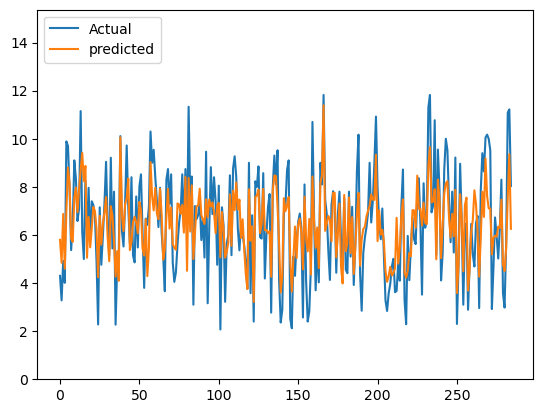

In [19]:
plt.plot(y_test)
plt.plot(y_test_pred)
plt.ylim(0, np.max(y_test)*1.3)
plt.legend(['Actual','predicted'], loc='upper left')